# ---- RLAGN HERG/LERG ML Application to LOFAR LoTSS DR2  ----
- LOFAR LoTSS DR2 AGN catalogue (Hardcastle et al. 2023)
- Feature engineering based on columns available in both SDSS and LoTSS (e.g., stellar mass, rest-frame color, emission-line ratios)
*In this model i have applied SDSS-trained ML classifier to the LoTSS RLAGN sample*

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
from astropy.stats import binom_conf_interval



## Data handling 

In [2]:
sdss = pd.read_csv('df_janssenhub.csv')
table = Table.read("data/agn-v1.1.fits") # 5,73,974

In [3]:
tbl = table[['Mass_median','z_best','U_rest','r_rest','FLUX_[OIII]_5006.77','FLUX_Hb_4861.32','FLUX_[NII]_6583.34','FLUX_Ha_6562.8','r_50','CLASS_HERG','CLASS_LINELERG']]
lotss = tbl.to_pandas()

In [4]:
# Identify HERG and LERG using CLASS_HERG and CLASS_LINELERG probabilities
threshold = 0.5
is_herg = (lotss['CLASS_HERG'] > threshold)
is_lerg = (lotss['CLASS_LINELERG'] > threshold)

# Clean, non-ambiguous cases: HERG or LERG, but not both
herg_only = is_herg & (~is_lerg)
lerg_only = is_lerg & (~is_herg)

indices = np.where(herg_only | lerg_only)[0]
ml_labels = np.zeros(len(indices), dtype=int)
ml_labels[herg_only[indices]] = 1  # HERG = 1, LERG = 0

lotss_ml = lotss.iloc[indices].copy()
lotss_ml['label'] = ml_labels  
print(f"RLAGN for ML: {len(lotss_ml)}")
print(f"HERG: {np.sum(ml_labels==1)}, LERG: {np.sum(ml_labels==0)}")


RLAGN for ML: 20577
HERG: 910, LERG: 19667


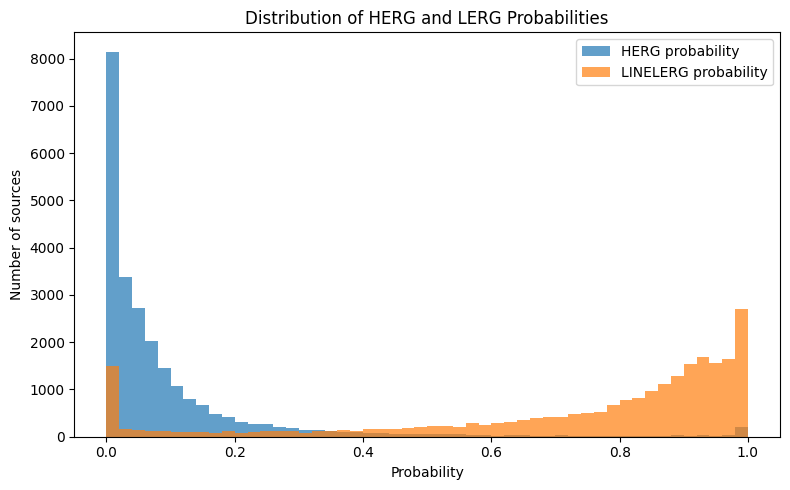

In [5]:
herg_probs = tbl['CLASS_HERG'][~tbl['CLASS_HERG'].mask]
lerg_probs = tbl['CLASS_LINELERG'][~tbl['CLASS_LINELERG'].mask]

plt.figure(figsize=(8,5))
plt.hist(herg_probs, bins=50, alpha=0.7, label='HERG probability')
plt.hist(lerg_probs, bins=50, alpha=0.7, label='LINELERG probability')
plt.xlabel('Probability')
plt.ylabel('Number of sources')
plt.title('Distribution of HERG and LERG Probabilities')
plt.legend()
plt.tight_layout()
plt.show()


## Feature Engineering 

In [6]:
# Features for LoTSS
lotss_ml['u_minus_r'] = lotss_ml['U_rest'] - lotss_ml['r_rest']
lotss_ml['OIII_Hb'] = np.log10(lotss_ml['FLUX_[OIII]_5006.77'] / lotss_ml['FLUX_Hb_4861.32'])
lotss_ml['NII_Ha']  = np.log10(lotss_ml['FLUX_[NII]_6583.34'] / lotss_ml['FLUX_Ha_6562.8'])

feature_col = ['Mass_median', 'u_minus_r', 'OIII_Hb', 'NII_Ha', 'r_50']
X_lotss = lotss_ml[feature_col].replace([np.inf, -np.inf], np.nan).values


In [7]:
# On SDSS:
feature_cols = ['log_stellar_mass', 'u-r', 'OIII_HB', 'NII_HA', 'R50_r']
X_sdss = sdss[feature_cols].values
y_sdss = sdss['label'].values

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X_train, X_val, y_train, y_val = train_test_split(
    X_sdss, y_sdss, test_size=0.3, random_state=42, stratify=y_sdss
)

model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    ))
])

model_pipeline.fit(X_train, y_train)

# Predict HERG probability for LoTSS RLAGN:
herg_proba = model_pipeline.predict_proba(X_lotss)[:, 1]
lotss_ml['HERG_probability'] = herg_proba


In [8]:
threshold = 0.5
ml_pred_label = (lotss_ml['HERG_probability'] > threshold).astype(int)  # 1=HERG, 0=LERG
true_label = lotss_ml['label'].values  # 1=HERG, 0=LERG

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print("Confusion Matrix:")
print(confusion_matrix(true_label, ml_pred_label))
print("Classification Report:")
print(classification_report(true_label, ml_pred_label))
print("ROC-AUC:", roc_auc_score(true_label, lotss_ml['HERG_probability']))


Confusion Matrix:
[[19192   475]
 [  557   353]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     19667
           1       0.43      0.39      0.41       910

    accuracy                           0.95     20577
   macro avg       0.70      0.68      0.69     20577
weighted avg       0.95      0.95      0.95     20577

ROC-AUC: 0.8844201280998962


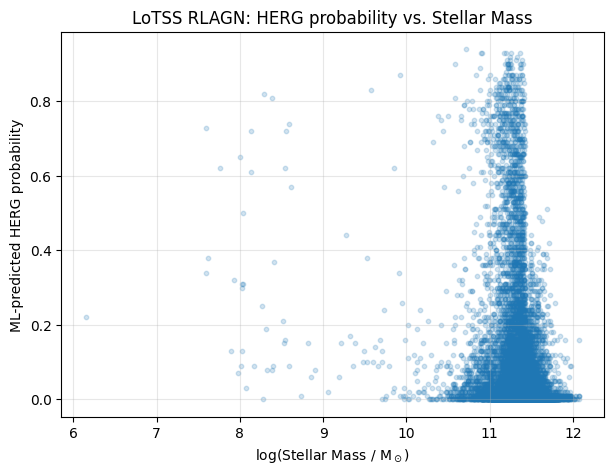

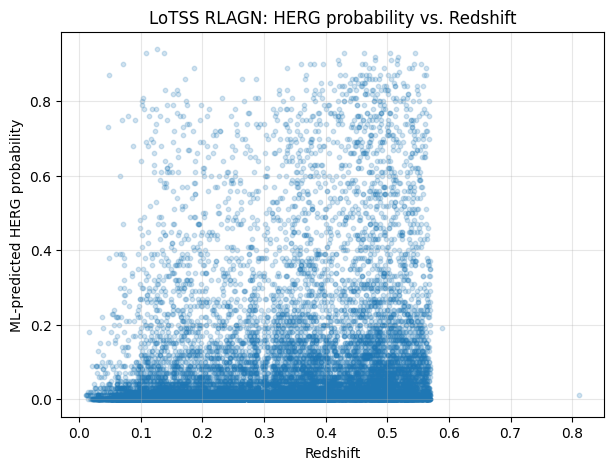

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(lotss_ml['Mass_median'], lotss_ml['HERG_probability'], alpha=0.2, s=10)
plt.xlabel('log(Stellar Mass / M$_\odot$)')
plt.ylabel('ML-predicted HERG probability')
plt.title('LoTSS RLAGN: HERG probability vs. Stellar Mass')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(lotss_ml['z_best'], lotss_ml['HERG_probability'], alpha=0.2, s=10)
plt.xlabel('Redshift')
plt.ylabel('ML-predicted HERG probability')
plt.title('LoTSS RLAGN: HERG probability vs. Redshift')
plt.grid(True, alpha=0.3)
plt.show()

